In [1]:
import numpy as np
from numpy import array
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import MaxPooling2D
from keras.layers import Dropout

from lstm_util import lstm_util

Using TensorFlow backend.


<h1>Global Dataframes and Variables</h1>

In [2]:
# We import the sample_submission.csv file as a way of determining
# the order of the rows in out output file
sample_submission = pd.read_csv("../sample_submission.csv")

# The fips_key.csv file contains standard information about each county
key = pd.read_csv("../data/us/processing_data/fips_key.csv", encoding='latin-1')

# Daily deaths contains the death count per day for each county.
# Cumulative deaths contains the total death count for each county
# by day.
daily_deaths = pd.read_csv("../data/us/covid/nyt_us_counties_daily.csv")
cumulative_deaths = pd.read_csv("../data/us/covid/deaths.csv")
county_land_areas = pd.read_csv("../data/us/demographics/county_land_areas.csv", encoding='latin1')

# List of all counties
all_fips = key["FIPS"].tolist()

# Relevent dates
today = cumulative_deaths.columns[-1]
yesterday = cumulative_deaths.columns[-2]
one_week_ago = cumulative_deaths.columns[-8]
two_weeks_ago = cumulative_deaths.columns[-15]
beginning = cumulative_deaths.columns[4]

<h1>Some Date Helper Functions</h1>

In [3]:
# Assume date is in format mm/dd/yy, convert to yyyy-mm-dd
def convert_date_to_yyyy_mm_dd(date):
    parts = date.split('/')
    
    # Ensure leading zeros if necessary
    if len(parts[0]) == 1:
        parts[0] = "0" + parts[0]
    
    if len(parts[1]) == 1:
        parts[1] = "0" + parts[1]
        
    return "2020" + "-" + parts[0] + "-" + parts[1]

# Assume date is in format yyyy-mm-dd, convert to mm/dd/yy
def convert_date_to_mm_dd_yy(date):
    parts = date.split('-')
    
    # Remove leading zeros if necessary
    if parts[1][0] == "0":
        parts[1] = parts[1][1:]
    
    if parts[2][0] == "0":
        parts[2] = parts[2][1:]
        
    return parts[1] + "/" + parts[2] + "/" + "20"

In [4]:
util = lstm_util(daily_deaths, cumulative_deaths, county_land_areas, key)

In [98]:
#fips = 6037
large_counties = []
in_steps = 14
out_steps = 14

for fips in all_fips:
    pop_per_square_mile = util.get_population_per_square_mile(fips)
    if pop_per_square_mile > 2000:
        large_counties.append(fips)

x_train = []
y_train = []

for fips in large_counties:
    deaths = list(util.get_deaths_list(fips, convert_date_to_yyyy_mm_dd(two_weeks_ago)))
    deaths = util.get_differenced_list(deaths)
    
    train_data = util.generate_train_data(deaths, in_steps, out_steps)
    x_train += train_data[0]
    y_train += train_data[1]
    
    #cases = list(util.get_cases_list(fips, convert_date_to_yyyy_mm_dd(two_weeks_ago)))
    
    #deaths = deaths[21:]
    
    #cases = util.get_differenced_list(cases)
    #deaths = util.get_differenced_list(deaths)
    
    #for i in range(len(deaths) - out_steps):
    #    seq_x, seq_y = cases[i:i+in_steps], deaths[i:i+out_steps]
    #    
    #    x_train.append(seq_x)
    #    y_train.append(seq_y)

x_train = array(x_train)
y_train = array(y_train)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [99]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(in_steps, 1)))
model.add(RepeatVector(out_steps))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')

In [100]:
model.fit(x_train, y_train, epochs=5000, verbose=1)

Epoch 1/5000
730/730 [==============================] - 1s 1ms/step - loss: 1434.4981
Epoch 2/5000
730/730 [==============================] - 0s 481us/step - loss: 1428.3556
Epoch 3/5000
730/730 [==============================] - 0s 496us/step - loss: 1421.6988
Epoch 4/5000
730/730 [==============================] - 0s 479us/step - loss: 1425.6197
Epoch 5/5000
730/730 [==============================] - 0s 489us/step - loss: 1420.1717
Epoch 6/5000
730/730 [==============================] - 0s 472us/step - loss: 1424.6586
Epoch 7/5000
730/730 [==============================] - 0s 486us/step - loss: 1417.7726
Epoch 8/5000
730/730 [==============================] - 0s 511us/step - loss: 1407.9304
Epoch 9/5000
730/730 [==============================] - 0s 497us/step - loss: 1418.1964
Epoch 10/5000
730/730 [==============================] - 0s 504us/step - loss: 1421.6222
Epoch 11/5000
730/730 [==============================] - 0s 519us/step - loss: 1406.9861
Epoch 12/5000
730/730 [=========

730/730 [==============================] - 0s 446us/step - loss: 1416.6366
Epoch 94/5000
730/730 [==============================] - 0s 447us/step - loss: 1409.8393
Epoch 95/5000
730/730 [==============================] - 0s 445us/step - loss: 1405.5622
Epoch 96/5000
730/730 [==============================] - 0s 440us/step - loss: 1397.0044
Epoch 97/5000
730/730 [==============================] - 0s 440us/step - loss: 1413.0997
Epoch 98/5000
730/730 [==============================] - 0s 441us/step - loss: 1414.4307
Epoch 99/5000
730/730 [==============================] - 0s 443us/step - loss: 1389.4095
Epoch 100/5000
730/730 [==============================] - 0s 452us/step - loss: 1399.4196
Epoch 101/5000
730/730 [==============================] - 0s 448us/step - loss: 1479.6233
Epoch 102/5000
730/730 [==============================] - 0s 444us/step - loss: 1403.0270
Epoch 103/5000
730/730 [==============================] - 0s 447us/step - loss: 1397.3517
Epoch 104/5000
730/730 [=======

730/730 [==============================] - 0s 455us/step - loss: 1407.2531
Epoch 185/5000
730/730 [==============================] - 0s 451us/step - loss: 1426.9332
Epoch 186/5000
730/730 [==============================] - 0s 453us/step - loss: 1411.9325
Epoch 187/5000
730/730 [==============================] - 0s 449us/step - loss: 1403.1736
Epoch 188/5000
730/730 [==============================] - 0s 452us/step - loss: 1395.2788
Epoch 189/5000
730/730 [==============================] - 0s 455us/step - loss: 1389.4797
Epoch 190/5000
730/730 [==============================] - 0s 452us/step - loss: 1403.3149
Epoch 191/5000
730/730 [==============================] - 0s 452us/step - loss: 1422.6931
Epoch 192/5000
730/730 [==============================] - 0s 452us/step - loss: 1383.0807
Epoch 193/5000
730/730 [==============================] - 0s 450us/step - loss: 1376.1856
Epoch 194/5000
730/730 [==============================] - 0s 455us/step - loss: 1361.1234
Epoch 195/5000
730/730 [=

730/730 [==============================] - 0s 446us/step - loss: 1039.7092
Epoch 276/5000
730/730 [==============================] - 0s 446us/step - loss: 1014.3979
Epoch 277/5000
730/730 [==============================] - 0s 451us/step - loss: 1001.2889
Epoch 278/5000
730/730 [==============================] - 0s 446us/step - loss: 975.4770
Epoch 279/5000
730/730 [==============================] - 0s 452us/step - loss: 957.9281
Epoch 280/5000
730/730 [==============================] - 0s 450us/step - loss: 941.1252
Epoch 281/5000
730/730 [==============================] - 0s 448us/step - loss: 926.9587
Epoch 282/5000
730/730 [==============================] - 0s 445us/step - loss: 1279.4272
Epoch 283/5000
730/730 [==============================] - 0s 447us/step - loss: 1340.3886
Epoch 284/5000
730/730 [==============================] - 0s 447us/step - loss: 1375.5968
Epoch 285/5000
730/730 [==============================] - 0s 448us/step - loss: 1303.6545
Epoch 286/5000
730/730 [=====

730/730 [==============================] - 0s 447us/step - loss: 947.9902
Epoch 367/5000
730/730 [==============================] - 0s 445us/step - loss: 1007.5460
Epoch 368/5000
730/730 [==============================] - 0s 446us/step - loss: 1060.8579
Epoch 369/5000
730/730 [==============================] - 0s 444us/step - loss: 1011.7766
Epoch 370/5000
730/730 [==============================] - 0s 450us/step - loss: 1025.3966
Epoch 371/5000
730/730 [==============================] - 0s 446us/step - loss: 1005.2667
Epoch 372/5000
730/730 [==============================] - 0s 448us/step - loss: 1191.5467
Epoch 373/5000
730/730 [==============================] - 0s 458us/step - loss: 1098.5427
Epoch 374/5000
730/730 [==============================] - 0s 544us/step - loss: 1034.5155
Epoch 375/5000
730/730 [==============================] - 0s 501us/step - loss: 1274.6417
Epoch 376/5000
730/730 [==============================] - 0s 450us/step - loss: 1356.5796
Epoch 377/5000
730/730 [==

730/730 [==============================] - 0s 447us/step - loss: 1402.1952
Epoch 458/5000
730/730 [==============================] - 0s 453us/step - loss: 1384.4430
Epoch 459/5000
730/730 [==============================] - 0s 448us/step - loss: 1371.8329
Epoch 460/5000
730/730 [==============================] - 0s 449us/step - loss: 1362.3345
Epoch 461/5000
730/730 [==============================] - 0s 445us/step - loss: 1355.8354
Epoch 462/5000
730/730 [==============================] - 0s 447us/step - loss: 1364.5258
Epoch 463/5000
730/730 [==============================] - 0s 451us/step - loss: 1339.9012
Epoch 464/5000
730/730 [==============================] - 0s 444us/step - loss: 1325.6004
Epoch 465/5000
730/730 [==============================] - 0s 444us/step - loss: 1351.3615
Epoch 466/5000
730/730 [==============================] - 0s 444us/step - loss: 1335.7377
Epoch 467/5000
730/730 [==============================] - 0s 444us/step - loss: 1320.9083
Epoch 468/5000
730/730 [=

730/730 [==============================] - 0s 444us/step - loss: 1257.4612
Epoch 549/5000
730/730 [==============================] - 0s 445us/step - loss: 1251.9593
Epoch 550/5000
730/730 [==============================] - 0s 446us/step - loss: 1246.0772
Epoch 551/5000
730/730 [==============================] - 0s 450us/step - loss: 1245.8510
Epoch 552/5000
730/730 [==============================] - 0s 445us/step - loss: 1245.1928
Epoch 553/5000
730/730 [==============================] - 0s 447us/step - loss: 1240.0977
Epoch 554/5000
730/730 [==============================] - 0s 448us/step - loss: 1240.4317
Epoch 555/5000
730/730 [==============================] - 0s 445us/step - loss: 1238.6820
Epoch 556/5000
730/730 [==============================] - 0s 449us/step - loss: 1231.8198
Epoch 557/5000
730/730 [==============================] - 0s 443us/step - loss: 1232.4385
Epoch 558/5000
730/730 [==============================] - 0s 442us/step - loss: 1225.0951
Epoch 559/5000
730/730 [=

730/730 [==============================] - 0s 448us/step - loss: 1209.7999
Epoch 640/5000
730/730 [==============================] - 0s 445us/step - loss: 1209.4780
Epoch 641/5000
730/730 [==============================] - 0s 447us/step - loss: 1212.2785
Epoch 642/5000
730/730 [==============================] - 0s 446us/step - loss: 1398.1567
Epoch 643/5000
730/730 [==============================] - 0s 444us/step - loss: 1263.6931
Epoch 644/5000
730/730 [==============================] - 0s 451us/step - loss: 1252.8512
Epoch 645/5000
730/730 [==============================] - 0s 454us/step - loss: 1233.7958
Epoch 646/5000
730/730 [==============================] - 0s 450us/step - loss: 1227.0483
Epoch 647/5000
730/730 [==============================] - 0s 445us/step - loss: 1217.4340
Epoch 648/5000
730/730 [==============================] - 0s 452us/step - loss: 1211.7995
Epoch 649/5000
730/730 [==============================] - 0s 446us/step - loss: 1204.8759
Epoch 650/5000
730/730 [=

730/730 [==============================] - 0s 453us/step - loss: 1386.3983
Epoch 731/5000
730/730 [==============================] - 0s 446us/step - loss: 1386.5080
Epoch 732/5000
730/730 [==============================] - 0s 446us/step - loss: 1383.1652
Epoch 733/5000
730/730 [==============================] - 0s 448us/step - loss: 1380.6467
Epoch 734/5000
730/730 [==============================] - 0s 450us/step - loss: 1385.5101
Epoch 735/5000
730/730 [==============================] - 0s 445us/step - loss: 1377.5297
Epoch 736/5000
730/730 [==============================] - 0s 449us/step - loss: 1379.1183
Epoch 737/5000
730/730 [==============================] - 0s 444us/step - loss: 1381.1037
Epoch 738/5000
730/730 [==============================] - 0s 449us/step - loss: 1377.1355
Epoch 739/5000
730/730 [==============================] - 0s 450us/step - loss: 1375.6765
Epoch 740/5000
730/730 [==============================] - 0s 444us/step - loss: 1370.6863
Epoch 741/5000
730/730 [=

730/730 [==============================] - 0s 456us/step - loss: 1374.8632
Epoch 821/5000
730/730 [==============================] - 0s 451us/step - loss: 1388.1890
Epoch 822/5000
730/730 [==============================] - 0s 444us/step - loss: 1369.0241
Epoch 823/5000
730/730 [==============================] - 0s 452us/step - loss: 1385.2086
Epoch 824/5000
730/730 [==============================] - 0s 449us/step - loss: 1395.3723
Epoch 825/5000
730/730 [==============================] - 0s 447us/step - loss: 1391.4931
Epoch 826/5000
730/730 [==============================] - 0s 451us/step - loss: 1371.0119
Epoch 827/5000
730/730 [==============================] - 0s 447us/step - loss: 1464.8960
Epoch 828/5000
730/730 [==============================] - 0s 453us/step - loss: 1479.2980
Epoch 829/5000
730/730 [==============================] - 0s 448us/step - loss: 1596.4882
Epoch 830/5000
730/730 [==============================] - 0s 448us/step - loss: 1563.8484
Epoch 831/5000
730/730 [=

730/730 [==============================] - 0s 452us/step - loss: 1371.9430
Epoch 912/5000
730/730 [==============================] - 0s 448us/step - loss: 1371.3754
Epoch 913/5000
730/730 [==============================] - 0s 447us/step - loss: 1372.5239
Epoch 914/5000
730/730 [==============================] - 0s 446us/step - loss: 1366.6258
Epoch 915/5000
730/730 [==============================] - 0s 447us/step - loss: 1369.4866
Epoch 916/5000
730/730 [==============================] - 0s 447us/step - loss: 1370.8816
Epoch 917/5000
730/730 [==============================] - 0s 446us/step - loss: 1365.1185
Epoch 918/5000
730/730 [==============================] - 0s 446us/step - loss: 1363.7974
Epoch 919/5000
730/730 [==============================] - 0s 450us/step - loss: 1368.3593
Epoch 920/5000
730/730 [==============================] - 0s 449us/step - loss: 1365.7231
Epoch 921/5000
730/730 [==============================] - 0s 446us/step - loss: 1363.6621
Epoch 922/5000
730/730 [=

730/730 [==============================] - 0s 450us/step - loss: 1411.7713
Epoch 1003/5000
730/730 [==============================] - 0s 450us/step - loss: 1406.8525
Epoch 1004/5000
730/730 [==============================] - 0s 454us/step - loss: 1409.1375
Epoch 1005/5000
730/730 [==============================] - 0s 455us/step - loss: 1407.9418
Epoch 1006/5000
730/730 [==============================] - 0s 449us/step - loss: 1408.9163
Epoch 1007/5000
730/730 [==============================] - 0s 451us/step - loss: 1407.1900
Epoch 1008/5000
730/730 [==============================] - 0s 447us/step - loss: 1402.6233
Epoch 1009/5000
730/730 [==============================] - 0s 455us/step - loss: 1404.4612
Epoch 1010/5000
730/730 [==============================] - 0s 447us/step - loss: 1397.3420
Epoch 1011/5000
730/730 [==============================] - 0s 448us/step - loss: 1400.4759
Epoch 1012/5000
730/730 [==============================] - 0s 449us/step - loss: 1400.8021
Epoch 1013/5000

730/730 [==============================] - 0s 457us/step - loss: 1284.4933
Epoch 1093/5000
730/730 [==============================] - 0s 456us/step - loss: 1269.6320
Epoch 1094/5000
730/730 [==============================] - 0s 452us/step - loss: 1327.1124
Epoch 1095/5000
730/730 [==============================] - 0s 448us/step - loss: 1284.6793
Epoch 1096/5000
730/730 [==============================] - 0s 448us/step - loss: 1269.1054
Epoch 1097/5000
730/730 [==============================] - 0s 457us/step - loss: 1257.4779
Epoch 1098/5000
730/730 [==============================] - 0s 451us/step - loss: 1257.2589
Epoch 1099/5000
730/730 [==============================] - 0s 445us/step - loss: 1249.0610
Epoch 1100/5000
730/730 [==============================] - 0s 451us/step - loss: 1241.1712
Epoch 1101/5000
730/730 [==============================] - 0s 449us/step - loss: 1235.5422
Epoch 1102/5000
730/730 [==============================] - 0s 448us/step - loss: 1232.7795
Epoch 1103/5000

730/730 [==============================] - 0s 450us/step - loss: 1283.7242
Epoch 1183/5000
730/730 [==============================] - 0s 446us/step - loss: 1284.8219
Epoch 1184/5000
730/730 [==============================] - 0s 451us/step - loss: 1281.8161
Epoch 1185/5000
730/730 [==============================] - 0s 452us/step - loss: 1280.7774
Epoch 1186/5000
730/730 [==============================] - 0s 451us/step - loss: 1274.4851
Epoch 1187/5000
730/730 [==============================] - 0s 449us/step - loss: 1266.8187
Epoch 1188/5000
730/730 [==============================] - 0s 449us/step - loss: 1269.9675
Epoch 1189/5000
730/730 [==============================] - 0s 449us/step - loss: 1290.3615
Epoch 1190/5000
730/730 [==============================] - 0s 450us/step - loss: 1285.9109
Epoch 1191/5000
730/730 [==============================] - 0s 454us/step - loss: 1259.4229
Epoch 1192/5000
730/730 [==============================] - 0s 448us/step - loss: 1286.7323
Epoch 1193/5000

730/730 [==============================] - 0s 453us/step - loss: 1253.6435
Epoch 1273/5000
730/730 [==============================] - 0s 448us/step - loss: 1255.1870
Epoch 1274/5000
730/730 [==============================] - 0s 450us/step - loss: 1262.7916
Epoch 1275/5000
730/730 [==============================] - 0s 449us/step - loss: 1249.1284
Epoch 1276/5000
730/730 [==============================] - 0s 448us/step - loss: 1255.6392
Epoch 1277/5000
730/730 [==============================] - 0s 452us/step - loss: 1244.3822
Epoch 1278/5000
730/730 [==============================] - 0s 454us/step - loss: 1236.2866
Epoch 1279/5000
730/730 [==============================] - 0s 451us/step - loss: 1233.7220
Epoch 1280/5000
730/730 [==============================] - 0s 450us/step - loss: 1258.9984
Epoch 1281/5000
730/730 [==============================] - 0s 452us/step - loss: 1244.9485
Epoch 1282/5000
730/730 [==============================] - 0s 448us/step - loss: 1257.6085
Epoch 1283/5000

730/730 [==============================] - 0s 452us/step - loss: 1195.7117
Epoch 1363/5000
730/730 [==============================] - 0s 450us/step - loss: 1190.0751
Epoch 1364/5000
730/730 [==============================] - 0s 449us/step - loss: 1189.5268
Epoch 1365/5000
730/730 [==============================] - 0s 453us/step - loss: 1179.6778
Epoch 1366/5000
730/730 [==============================] - 0s 450us/step - loss: 1230.5536
Epoch 1367/5000
730/730 [==============================] - 0s 449us/step - loss: 218296.7818
Epoch 1368/5000
730/730 [==============================] - 0s 451us/step - loss: 2002.0180
Epoch 1369/5000
730/730 [==============================] - 0s 451us/step - loss: 4576.6037
Epoch 1370/5000
730/730 [==============================] - 0s 452us/step - loss: 2176.5043
Epoch 1371/5000
730/730 [==============================] - 0s 451us/step - loss: 1652.1588
Epoch 1372/5000
730/730 [==============================] - 0s 453us/step - loss: 1508.2298
Epoch 1373/50

730/730 [==============================] - 0s 454us/step - loss: 1306.7998
Epoch 1453/5000
730/730 [==============================] - 0s 450us/step - loss: 1369.4053
Epoch 1454/5000
730/730 [==============================] - 0s 455us/step - loss: 1632.4676
Epoch 1455/5000
730/730 [==============================] - 0s 450us/step - loss: 1468.0650
Epoch 1456/5000
730/730 [==============================] - 0s 453us/step - loss: 1361.5503
Epoch 1457/5000
730/730 [==============================] - 0s 449us/step - loss: 1346.8101
Epoch 1458/5000
730/730 [==============================] - 0s 448us/step - loss: 1314.9283
Epoch 1459/5000
730/730 [==============================] - 0s 449us/step - loss: 1436.2499
Epoch 1460/5000
730/730 [==============================] - 0s 469us/step - loss: 1431.8622
Epoch 1461/5000
730/730 [==============================] - 0s 449us/step - loss: 1381.5127
Epoch 1462/5000
730/730 [==============================] - 0s 454us/step - loss: 1377.4206
Epoch 1463/5000

730/730 [==============================] - 0s 450us/step - loss: 1096.2083
Epoch 1543/5000
730/730 [==============================] - 0s 451us/step - loss: 1071.0466
Epoch 1544/5000
730/730 [==============================] - 0s 449us/step - loss: 1068.2404
Epoch 1545/5000
730/730 [==============================] - 0s 448us/step - loss: 1070.2375
Epoch 1546/5000
730/730 [==============================] - 0s 455us/step - loss: 1066.7430
Epoch 1547/5000
730/730 [==============================] - 0s 453us/step - loss: 1068.9197
Epoch 1548/5000
730/730 [==============================] - 0s 449us/step - loss: 1052.3583
Epoch 1549/5000
730/730 [==============================] - 0s 453us/step - loss: 1039.4991
Epoch 1550/5000
730/730 [==============================] - 0s 449us/step - loss: 1035.5113
Epoch 1551/5000
730/730 [==============================] - 0s 455us/step - loss: 1018.7697
Epoch 1552/5000
730/730 [==============================] - 0s 452us/step - loss: 1036.6667
Epoch 1553/5000

730/730 [==============================] - 0s 469us/step - loss: 1607.5991
Epoch 1633/5000
730/730 [==============================] - 0s 450us/step - loss: 1336.6529
Epoch 1634/5000
730/730 [==============================] - 0s 449us/step - loss: 1309.9173
Epoch 1635/5000
730/730 [==============================] - 0s 484us/step - loss: 2217.7132
Epoch 1636/5000
730/730 [==============================] - 0s 457us/step - loss: 1780424819.7864
Epoch 1637/5000
730/730 [==============================] - 0s 466us/step - loss: 1654.4830
Epoch 1638/5000
730/730 [==============================] - 0s 472us/step - loss: 1562.0315
Epoch 1639/5000
730/730 [==============================] - 0s 527us/step - loss: 1457.4047
Epoch 1640/5000
730/730 [==============================] - 0s 439us/step - loss: 1435.0031
Epoch 1641/5000
730/730 [==============================] - 0s 432us/step - loss: 1401.8237
Epoch 1642/5000
730/730 [==============================] - 0s 460us/step - loss: 1389.0016
Epoch 164

730/730 [==============================] - 0s 452us/step - loss: 1222.7825
Epoch 1723/5000
730/730 [==============================] - 0s 448us/step - loss: 1219.4693
Epoch 1724/5000
730/730 [==============================] - 0s 453us/step - loss: 1216.1337
Epoch 1725/5000
730/730 [==============================] - 0s 451us/step - loss: 1212.9754
Epoch 1726/5000
730/730 [==============================] - 0s 454us/step - loss: 1210.1249
Epoch 1727/5000
730/730 [==============================] - 0s 453us/step - loss: 1208.2420
Epoch 1728/5000
730/730 [==============================] - 0s 450us/step - loss: 1204.1609
Epoch 1729/5000
730/730 [==============================] - 0s 448us/step - loss: 1201.5531
Epoch 1730/5000
730/730 [==============================] - 0s 451us/step - loss: 1200.7640
Epoch 1731/5000
730/730 [==============================] - 0s 450us/step - loss: 1199.5791
Epoch 1732/5000
730/730 [==============================] - 0s 452us/step - loss: 1197.8598
Epoch 1733/5000

730/730 [==============================] - 0s 454us/step - loss: 1127.0730
Epoch 1813/5000
730/730 [==============================] - 0s 450us/step - loss: 1117.1753
Epoch 1814/5000
730/730 [==============================] - 0s 454us/step - loss: 1119.4635
Epoch 1815/5000
730/730 [==============================] - 0s 452us/step - loss: 1116.8497
Epoch 1816/5000
730/730 [==============================] - 0s 452us/step - loss: 1106.5020
Epoch 1817/5000
730/730 [==============================] - 0s 449us/step - loss: 1120.2366
Epoch 1818/5000
730/730 [==============================] - 0s 456us/step - loss: 1107.0024
Epoch 1819/5000
730/730 [==============================] - 0s 449us/step - loss: 1229.2896
Epoch 1820/5000
730/730 [==============================] - 0s 453us/step - loss: 1196.8787
Epoch 1821/5000
730/730 [==============================] - 0s 453us/step - loss: 1204.0834
Epoch 1822/5000
730/730 [==============================] - 0s 447us/step - loss: 1201.2068
Epoch 1823/5000

730/730 [==============================] - 0s 459us/step - loss: 1098.0200
Epoch 1903/5000
730/730 [==============================] - 0s 451us/step - loss: 1078.3018
Epoch 1904/5000
730/730 [==============================] - 0s 452us/step - loss: 1072.1423
Epoch 1905/5000
730/730 [==============================] - 0s 452us/step - loss: 1069.9556
Epoch 1906/5000
730/730 [==============================] - 0s 453us/step - loss: 1069.7328
Epoch 1907/5000
730/730 [==============================] - 0s 455us/step - loss: 1066.4726
Epoch 1908/5000
730/730 [==============================] - 0s 449us/step - loss: 1066.2842
Epoch 1909/5000
730/730 [==============================] - 0s 453us/step - loss: 1067.0425
Epoch 1910/5000
730/730 [==============================] - 0s 453us/step - loss: 1069.1477
Epoch 1911/5000
730/730 [==============================] - 0s 452us/step - loss: 1065.5345
Epoch 1912/5000
730/730 [==============================] - 0s 455us/step - loss: 1063.1961
Epoch 1913/5000

730/730 [==============================] - 0s 458us/step - loss: 1091.2439
Epoch 1993/5000
730/730 [==============================] - 0s 450us/step - loss: 1082.5688
Epoch 1994/5000
730/730 [==============================] - 0s 448us/step - loss: 1098.0193
Epoch 1995/5000
730/730 [==============================] - 0s 456us/step - loss: 1082.4845
Epoch 1996/5000
730/730 [==============================] - 0s 450us/step - loss: 1131.2771
Epoch 1997/5000
730/730 [==============================] - 0s 452us/step - loss: 1178.0841
Epoch 1998/5000
730/730 [==============================] - 0s 450us/step - loss: 1176.2183
Epoch 1999/5000
730/730 [==============================] - 0s 452us/step - loss: 1202.4304
Epoch 2000/5000
730/730 [==============================] - 0s 453us/step - loss: 1246.8868
Epoch 2001/5000
730/730 [==============================] - 0s 454us/step - loss: 1204.0580
Epoch 2002/5000
730/730 [==============================] - 0s 452us/step - loss: 1180.9077
Epoch 2003/5000

730/730 [==============================] - 0s 454us/step - loss: 607.9927
Epoch 2083/5000
730/730 [==============================] - 0s 449us/step - loss: 650.6662
Epoch 2084/5000
730/730 [==============================] - 0s 452us/step - loss: 619.5170
Epoch 2085/5000
730/730 [==============================] - 0s 450us/step - loss: 647.0766
Epoch 2086/5000
730/730 [==============================] - 0s 455us/step - loss: 1038.6412
Epoch 2087/5000
730/730 [==============================] - 0s 453us/step - loss: 1309.8756
Epoch 2088/5000
730/730 [==============================] - 0s 459us/step - loss: 921.6309
Epoch 2089/5000
730/730 [==============================] - 0s 451us/step - loss: 838.4664
Epoch 2090/5000
730/730 [==============================] - 0s 450us/step - loss: 819.7762
Epoch 2091/5000
730/730 [==============================] - 0s 453us/step - loss: 858.3499
Epoch 2092/5000
730/730 [==============================] - 0s 450us/step - loss: 989.0005
Epoch 2093/5000
730/730 

730/730 [==============================] - 0s 450us/step - loss: 728.2454
Epoch 2174/5000
730/730 [==============================] - 0s 449us/step - loss: 723.2287
Epoch 2175/5000
730/730 [==============================] - 0s 451us/step - loss: 733.2854
Epoch 2176/5000
730/730 [==============================] - 0s 452us/step - loss: 701.1267
Epoch 2177/5000
730/730 [==============================] - 0s 455us/step - loss: 653.2590
Epoch 2178/5000
730/730 [==============================] - 0s 456us/step - loss: 641.8204
Epoch 2179/5000
730/730 [==============================] - 0s 449us/step - loss: 679.3314
Epoch 2180/5000
730/730 [==============================] - 0s 453us/step - loss: 703.1305
Epoch 2181/5000
730/730 [==============================] - 0s 450us/step - loss: 808.3951
Epoch 2182/5000
730/730 [==============================] - 0s 454us/step - loss: 1096.7600
Epoch 2183/5000
730/730 [==============================] - 0s 453us/step - loss: 1268.3983
Epoch 2184/5000
730/730 

730/730 [==============================] - 0s 449us/step - loss: 1224.0135
Epoch 2264/5000
730/730 [==============================] - 0s 458us/step - loss: 1211.5673
Epoch 2265/5000
730/730 [==============================] - 0s 450us/step - loss: 1177.5187
Epoch 2266/5000
730/730 [==============================] - 0s 454us/step - loss: 1160.4899
Epoch 2267/5000
730/730 [==============================] - 0s 452us/step - loss: 1148.9663
Epoch 2268/5000
730/730 [==============================] - 0s 455us/step - loss: 1195.4757
Epoch 2269/5000
730/730 [==============================] - 0s 452us/step - loss: 1150.2494
Epoch 2270/5000
730/730 [==============================] - 0s 450us/step - loss: 1114.6848
Epoch 2271/5000
730/730 [==============================] - 0s 450us/step - loss: 1134.1107
Epoch 2272/5000
730/730 [==============================] - 0s 448us/step - loss: 1108.5737
Epoch 2273/5000
730/730 [==============================] - 0s 452us/step - loss: 1122.1339
Epoch 2274/5000

730/730 [==============================] - 0s 455us/step - loss: 873.2924
Epoch 2354/5000
730/730 [==============================] - 0s 450us/step - loss: 870.3166
Epoch 2355/5000
730/730 [==============================] - 0s 447us/step - loss: 891.0589
Epoch 2356/5000
730/730 [==============================] - 0s 451us/step - loss: 895.3612
Epoch 2357/5000
730/730 [==============================] - 0s 453us/step - loss: 862.7131
Epoch 2358/5000
730/730 [==============================] - 0s 451us/step - loss: 861.5970
Epoch 2359/5000
730/730 [==============================] - 0s 448us/step - loss: 847.5383
Epoch 2360/5000
730/730 [==============================] - 0s 452us/step - loss: 842.4310
Epoch 2361/5000
730/730 [==============================] - 0s 456us/step - loss: 817.0841
Epoch 2362/5000
730/730 [==============================] - 0s 457us/step - loss: 811.5967
Epoch 2363/5000
730/730 [==============================] - 0s 451us/step - loss: 804.2380
Epoch 2364/5000
730/730 [=

730/730 [==============================] - 0s 458us/step - loss: 1177.6184
Epoch 2444/5000
730/730 [==============================] - 0s 450us/step - loss: 1195.7445
Epoch 2445/5000
730/730 [==============================] - 0s 453us/step - loss: 1187.5536
Epoch 2446/5000
730/730 [==============================] - 0s 453us/step - loss: 1142.7768
Epoch 2447/5000
730/730 [==============================] - 0s 459us/step - loss: 1207.7045
Epoch 2448/5000
730/730 [==============================] - 0s 455us/step - loss: 1182.7409
Epoch 2449/5000
730/730 [==============================] - 0s 454us/step - loss: 1229.5347
Epoch 2450/5000
730/730 [==============================] - 0s 455us/step - loss: 1409.8417
Epoch 2451/5000
730/730 [==============================] - 0s 455us/step - loss: 1510.0489
Epoch 2452/5000
730/730 [==============================] - 0s 453us/step - loss: 1486.6753
Epoch 2453/5000
730/730 [==============================] - 0s 451us/step - loss: 1440.1149
Epoch 2454/5000

730/730 [==============================] - 0s 451us/step - loss: 1297.5454
Epoch 2534/5000
730/730 [==============================] - 0s 453us/step - loss: 1273.2841
Epoch 2535/5000
730/730 [==============================] - 0s 453us/step - loss: 1274.8056
Epoch 2536/5000
730/730 [==============================] - 0s 454us/step - loss: 1294.7347
Epoch 2537/5000
730/730 [==============================] - 0s 453us/step - loss: 1345.8080
Epoch 2538/5000
730/730 [==============================] - 0s 452us/step - loss: 1316.0102
Epoch 2539/5000
730/730 [==============================] - 0s 456us/step - loss: 1255.7946
Epoch 2540/5000
730/730 [==============================] - 0s 455us/step - loss: 1232.1983
Epoch 2541/5000
730/730 [==============================] - 0s 453us/step - loss: 1253.7540
Epoch 2542/5000
730/730 [==============================] - 0s 452us/step - loss: 1237.1976
Epoch 2543/5000
730/730 [==============================] - 0s 450us/step - loss: 1213.1573
Epoch 2544/5000

730/730 [==============================] - 0s 457us/step - loss: 1033.4687
Epoch 2624/5000
730/730 [==============================] - 0s 455us/step - loss: 1931.5261
Epoch 2625/5000
730/730 [==============================] - 0s 457us/step - loss: 3050.2390
Epoch 2626/5000
730/730 [==============================] - 0s 459us/step - loss: 1647.2217
Epoch 2627/5000
730/730 [==============================] - 0s 457us/step - loss: 1560.3935
Epoch 2628/5000
730/730 [==============================] - 0s 463us/step - loss: 2158.7660
Epoch 2629/5000
730/730 [==============================] - 0s 454us/step - loss: 4262.5539
Epoch 2630/5000
730/730 [==============================] - 0s 456us/step - loss: 1608.3925
Epoch 2631/5000
730/730 [==============================] - 0s 454us/step - loss: 1641.3122
Epoch 2632/5000
730/730 [==============================] - 0s 455us/step - loss: 1674.5238
Epoch 2633/5000
730/730 [==============================] - 0s 460us/step - loss: 1512.4947
Epoch 2634/5000

730/730 [==============================] - 0s 453us/step - loss: 1149.8547
Epoch 2714/5000
730/730 [==============================] - 0s 452us/step - loss: 1142.5526
Epoch 2715/5000
730/730 [==============================] - 0s 456us/step - loss: 1148.2542
Epoch 2716/5000
730/730 [==============================] - 0s 456us/step - loss: 1167.6746
Epoch 2717/5000
730/730 [==============================] - 0s 454us/step - loss: 1304.3691
Epoch 2718/5000
730/730 [==============================] - 0s 450us/step - loss: 1181.3889
Epoch 2719/5000
730/730 [==============================] - 0s 453us/step - loss: 1202.9977
Epoch 2720/5000
730/730 [==============================] - 0s 448us/step - loss: 1197.0360
Epoch 2721/5000
730/730 [==============================] - 0s 452us/step - loss: 1281.3909
Epoch 2722/5000
730/730 [==============================] - 0s 453us/step - loss: 1344.2010
Epoch 2723/5000
730/730 [==============================] - 0s 454us/step - loss: 1390.2613
Epoch 2724/5000

730/730 [==============================] - 0s 454us/step - loss: 1198.0289
Epoch 2804/5000
730/730 [==============================] - 0s 450us/step - loss: 1161.8414
Epoch 2805/5000
730/730 [==============================] - 0s 453us/step - loss: 1104.7825
Epoch 2806/5000
730/730 [==============================] - 0s 454us/step - loss: 1093.2493
Epoch 2807/5000
730/730 [==============================] - 0s 452us/step - loss: 1139.1766
Epoch 2808/5000
730/730 [==============================] - 0s 451us/step - loss: 1144.8739
Epoch 2809/5000
730/730 [==============================] - 0s 457us/step - loss: 1095.9778
Epoch 2810/5000
730/730 [==============================] - 0s 453us/step - loss: 1214.2739
Epoch 2811/5000
730/730 [==============================] - 0s 454us/step - loss: 1217.7834
Epoch 2812/5000
730/730 [==============================] - 0s 453us/step - loss: 1122.6723
Epoch 2813/5000
730/730 [==============================] - 0s 453us/step - loss: 1145.2049
Epoch 2814/5000

730/730 [==============================] - 0s 453us/step - loss: 1237.5550
Epoch 2894/5000
730/730 [==============================] - 0s 452us/step - loss: 1233.7874
Epoch 2895/5000
730/730 [==============================] - 0s 451us/step - loss: 1230.6742
Epoch 2896/5000
730/730 [==============================] - 0s 460us/step - loss: 1227.7710
Epoch 2897/5000
730/730 [==============================] - 0s 454us/step - loss: 1221.9538
Epoch 2898/5000
730/730 [==============================] - 0s 455us/step - loss: 1218.2820
Epoch 2899/5000
730/730 [==============================] - 0s 451us/step - loss: 1216.4013
Epoch 2900/5000
730/730 [==============================] - 0s 451us/step - loss: 1222.6400
Epoch 2901/5000
730/730 [==============================] - 0s 451us/step - loss: 2104.9257
Epoch 2902/5000
730/730 [==============================] - 0s 457us/step - loss: 3098.8547
Epoch 2903/5000
730/730 [==============================] - 0s 456us/step - loss: 2112.8182
Epoch 2904/5000

730/730 [==============================] - 0s 457us/step - loss: 1268.1558
Epoch 2984/5000
730/730 [==============================] - 0s 452us/step - loss: 1259.1786
Epoch 2985/5000
730/730 [==============================] - 0s 452us/step - loss: 1259.2992
Epoch 2986/5000
730/730 [==============================] - 0s 455us/step - loss: 2544.3763
Epoch 2987/5000
730/730 [==============================] - 0s 450us/step - loss: 31728.7887
Epoch 2988/5000
730/730 [==============================] - 0s 453us/step - loss: 1756.4156
Epoch 2989/5000
730/730 [==============================] - 0s 458us/step - loss: 1615.1709
Epoch 2990/5000
730/730 [==============================] - 0s 452us/step - loss: 1494.2531
Epoch 2991/5000
730/730 [==============================] - 0s 448us/step - loss: 1460.2461
Epoch 2992/5000
730/730 [==============================] - 0s 452us/step - loss: 1428.9639
Epoch 2993/5000
730/730 [==============================] - 0s 453us/step - loss: 1416.0483
Epoch 2994/500

730/730 [==============================] - 0s 467us/step - loss: 1335.5492
Epoch 3074/5000
730/730 [==============================] - 0s 558us/step - loss: 1388.7036
Epoch 3075/5000
730/730 [==============================] - 0s 472us/step - loss: 1327.5530
Epoch 3076/5000
730/730 [==============================] - 0s 516us/step - loss: 1316.7026
Epoch 3077/5000
730/730 [==============================] - 0s 457us/step - loss: 1294.3461
Epoch 3078/5000
730/730 [==============================] - 0s 459us/step - loss: 1278.0271
Epoch 3079/5000
730/730 [==============================] - 0s 456us/step - loss: 1275.3801
Epoch 3080/5000
730/730 [==============================] - 0s 453us/step - loss: 1271.7203
Epoch 3081/5000
730/730 [==============================] - 0s 452us/step - loss: 1308.5158
Epoch 3082/5000
730/730 [==============================] - 0s 459us/step - loss: 1306.1278
Epoch 3083/5000
730/730 [==============================] - 0s 452us/step - loss: 1319.4974
Epoch 3084/5000

730/730 [==============================] - 0s 463us/step - loss: 1352.4873
Epoch 3164/5000
730/730 [==============================] - 0s 454us/step - loss: 1343.3304
Epoch 3165/5000
730/730 [==============================] - 0s 453us/step - loss: 1378.4269
Epoch 3166/5000
730/730 [==============================] - 0s 452us/step - loss: 1338.1454
Epoch 3167/5000
730/730 [==============================] - 0s 452us/step - loss: 1357.6027
Epoch 3168/5000
730/730 [==============================] - 0s 454us/step - loss: 1380.5861
Epoch 3169/5000
730/730 [==============================] - 0s 453us/step - loss: 1472.5363
Epoch 3170/5000
730/730 [==============================] - 0s 453us/step - loss: 1459.1963
Epoch 3171/5000
730/730 [==============================] - 0s 455us/step - loss: 1422.4791
Epoch 3172/5000
730/730 [==============================] - 0s 452us/step - loss: 1408.0305
Epoch 3173/5000
730/730 [==============================] - 0s 455us/step - loss: 1395.6314
Epoch 3174/5000

730/730 [==============================] - 0s 456us/step - loss: 1306.5622
Epoch 3254/5000
730/730 [==============================] - 0s 466us/step - loss: 1340.0011
Epoch 3255/5000
730/730 [==============================] - 0s 451us/step - loss: 1370.4812
Epoch 3256/5000
730/730 [==============================] - 0s 454us/step - loss: 1300.2502
Epoch 3257/5000
730/730 [==============================] - 0s 450us/step - loss: 1301.7036
Epoch 3258/5000
730/730 [==============================] - 0s 453us/step - loss: 1308.0833
Epoch 3259/5000
730/730 [==============================] - 0s 457us/step - loss: 1288.7821
Epoch 3260/5000
730/730 [==============================] - 0s 454us/step - loss: 1285.3202
Epoch 3261/5000
730/730 [==============================] - 0s 453us/step - loss: 1294.3717
Epoch 3262/5000
730/730 [==============================] - 0s 452us/step - loss: 1279.6234
Epoch 3263/5000
730/730 [==============================] - 0s 448us/step - loss: 1299.3607
Epoch 3264/5000

730/730 [==============================] - 0s 453us/step - loss: 1288.5381
Epoch 3343/5000
730/730 [==============================] - 0s 453us/step - loss: 1292.7770
Epoch 3344/5000
730/730 [==============================] - 0s 453us/step - loss: 1276.7669
Epoch 3345/5000
730/730 [==============================] - 0s 453us/step - loss: 1259.7929
Epoch 3346/5000
730/730 [==============================] - 0s 450us/step - loss: 1293.5160
Epoch 3347/5000
730/730 [==============================] - 0s 454us/step - loss: 1379.8859
Epoch 3348/5000
730/730 [==============================] - 0s 454us/step - loss: 1284.4581
Epoch 3349/5000
730/730 [==============================] - 0s 452us/step - loss: 1279.3468
Epoch 3350/5000
730/730 [==============================] - 0s 452us/step - loss: 1262.6222
Epoch 3351/5000
730/730 [==============================] - 0s 451us/step - loss: 1261.2841
Epoch 3352/5000
730/730 [==============================] - 0s 454us/step - loss: 1257.5698
Epoch 3353/5000

730/730 [==============================] - 0s 458us/step - loss: 1382.9680
Epoch 3433/5000
730/730 [==============================] - 0s 452us/step - loss: 1382.7937
Epoch 3434/5000
730/730 [==============================] - 0s 452us/step - loss: 1377.6496
Epoch 3435/5000
730/730 [==============================] - 0s 455us/step - loss: 1379.3314
Epoch 3436/5000
730/730 [==============================] - 0s 453us/step - loss: 1379.1878
Epoch 3437/5000
730/730 [==============================] - 0s 455us/step - loss: 1381.5559
Epoch 3438/5000
730/730 [==============================] - 0s 454us/step - loss: 1377.0984
Epoch 3439/5000
730/730 [==============================] - 0s 451us/step - loss: 1374.8528
Epoch 3440/5000
730/730 [==============================] - 0s 454us/step - loss: 1371.4441
Epoch 3441/5000
730/730 [==============================] - 0s 452us/step - loss: 1372.1991
Epoch 3442/5000
730/730 [==============================] - 0s 452us/step - loss: 1363.9461
Epoch 3443/5000

730/730 [==============================] - 0s 456us/step - loss: 1355.2326
Epoch 3523/5000
730/730 [==============================] - 0s 449us/step - loss: 1355.0388
Epoch 3524/5000
730/730 [==============================] - 0s 455us/step - loss: 1353.2203
Epoch 3525/5000
730/730 [==============================] - 0s 455us/step - loss: 1352.5676
Epoch 3526/5000
730/730 [==============================] - 0s 453us/step - loss: 1350.5845
Epoch 3527/5000
730/730 [==============================] - 0s 457us/step - loss: 1350.7581
Epoch 3528/5000
730/730 [==============================] - 0s 455us/step - loss: 1348.9952
Epoch 3529/5000
730/730 [==============================] - 0s 452us/step - loss: 1348.9478
Epoch 3530/5000
730/730 [==============================] - 0s 451us/step - loss: 1347.5005
Epoch 3531/5000
730/730 [==============================] - 0s 456us/step - loss: 1347.0812
Epoch 3532/5000
730/730 [==============================] - 0s 457us/step - loss: 1346.2921
Epoch 3533/5000

730/730 [==============================] - 0s 456us/step - loss: 1350.8845
Epoch 3613/5000
730/730 [==============================] - 0s 455us/step - loss: 1340.4320
Epoch 3614/5000
730/730 [==============================] - 0s 454us/step - loss: 1397.2370
Epoch 3615/5000
730/730 [==============================] - 0s 453us/step - loss: 1418.8518
Epoch 3616/5000
730/730 [==============================] - 0s 454us/step - loss: 1382.4580
Epoch 3617/5000
730/730 [==============================] - 0s 453us/step - loss: 1391.7239
Epoch 3618/5000
730/730 [==============================] - 0s 456us/step - loss: 1426.4428
Epoch 3619/5000
730/730 [==============================] - 0s 457us/step - loss: 1451.0071
Epoch 3620/5000
730/730 [==============================] - 0s 452us/step - loss: 1391.4239
Epoch 3621/5000
730/730 [==============================] - 0s 453us/step - loss: 1529.5962
Epoch 3622/5000
730/730 [==============================] - 0s 449us/step - loss: 1527.9500
Epoch 3623/5000

730/730 [==============================] - 0s 459us/step - loss: 1413.1498
Epoch 3703/5000
730/730 [==============================] - 0s 455us/step - loss: 1412.9374
Epoch 3704/5000
730/730 [==============================] - 0s 453us/step - loss: 1412.6784
Epoch 3705/5000
730/730 [==============================] - 0s 460us/step - loss: 1412.4605
Epoch 3706/5000
730/730 [==============================] - 0s 455us/step - loss: 1412.0987
Epoch 3707/5000
730/730 [==============================] - 0s 452us/step - loss: 1411.7176
Epoch 3708/5000
730/730 [==============================] - 0s 453us/step - loss: 1411.3632
Epoch 3709/5000
730/730 [==============================] - 0s 452us/step - loss: 1407.3217
Epoch 3710/5000
730/730 [==============================] - 0s 454us/step - loss: 1400.2491
Epoch 3711/5000
730/730 [==============================] - 0s 452us/step - loss: 1395.4192
Epoch 3712/5000
730/730 [==============================] - 0s 452us/step - loss: 1390.9309
Epoch 3713/5000

730/730 [==============================] - 0s 455us/step - loss: 1335.5791
Epoch 3793/5000
730/730 [==============================] - 0s 457us/step - loss: 1334.5151
Epoch 3794/5000
730/730 [==============================] - 0s 450us/step - loss: 1334.3317
Epoch 3795/5000
730/730 [==============================] - 0s 453us/step - loss: 1334.5321
Epoch 3796/5000
730/730 [==============================] - 0s 452us/step - loss: 1333.8416
Epoch 3797/5000
730/730 [==============================] - 0s 454us/step - loss: 1333.6952
Epoch 3798/5000
730/730 [==============================] - 0s 453us/step - loss: 1333.6152
Epoch 3799/5000
730/730 [==============================] - 0s 453us/step - loss: 1333.5674
Epoch 3800/5000
730/730 [==============================] - 0s 458us/step - loss: 1333.5137
Epoch 3801/5000
730/730 [==============================] - 0s 450us/step - loss: 1333.4609
Epoch 3802/5000
730/730 [==============================] - 0s 459us/step - loss: 1333.4359
Epoch 3803/5000

730/730 [==============================] - 0s 457us/step - loss: 1333.0991
Epoch 3883/5000
730/730 [==============================] - 0s 453us/step - loss: 1334.3271
Epoch 3884/5000
730/730 [==============================] - 0s 454us/step - loss: 1334.2795
Epoch 3885/5000
730/730 [==============================] - 0s 452us/step - loss: 1335.1570
Epoch 3886/5000
730/730 [==============================] - 0s 453us/step - loss: 1334.9556
Epoch 3887/5000
730/730 [==============================] - 0s 454us/step - loss: 1333.7443
Epoch 3888/5000
730/730 [==============================] - 0s 455us/step - loss: 1333.0521
Epoch 3889/5000
730/730 [==============================] - 0s 455us/step - loss: 1332.7662
Epoch 3890/5000
730/730 [==============================] - 0s 455us/step - loss: 1332.6767
Epoch 3891/5000
730/730 [==============================] - 0s 455us/step - loss: 1332.7496
Epoch 3892/5000
730/730 [==============================] - 0s 451us/step - loss: 1332.2677
Epoch 3893/5000

730/730 [==============================] - 0s 452us/step - loss: 1348.4452
Epoch 3972/5000
730/730 [==============================] - 0s 454us/step - loss: 1347.3179
Epoch 3973/5000
730/730 [==============================] - 0s 451us/step - loss: 1739.7257
Epoch 3974/5000
730/730 [==============================] - 0s 451us/step - loss: 1432.9264
Epoch 3975/5000
730/730 [==============================] - 0s 451us/step - loss: 1712.1907
Epoch 3976/5000
730/730 [==============================] - 0s 454us/step - loss: 1647.2834
Epoch 3977/5000
730/730 [==============================] - 0s 453us/step - loss: 1471.6472
Epoch 3978/5000
730/730 [==============================] - 0s 454us/step - loss: 1460.0583
Epoch 3979/5000
730/730 [==============================] - 0s 453us/step - loss: 1444.0816
Epoch 3980/5000
730/730 [==============================] - 0s 451us/step - loss: 403356541346.9569
Epoch 3981/5000
730/730 [==============================] - 0s 458us/step - loss: 1431.0551
Epoch 3

730/730 [==============================] - 0s 459us/step - loss: 1305.7003
Epoch 4062/5000
730/730 [==============================] - 0s 454us/step - loss: 1304.6678
Epoch 4063/5000
730/730 [==============================] - 0s 451us/step - loss: 1300.6396
Epoch 4064/5000
730/730 [==============================] - 0s 459us/step - loss: 1299.2345
Epoch 4065/5000
730/730 [==============================] - 0s 453us/step - loss: 1298.2699
Epoch 4066/5000
730/730 [==============================] - 0s 454us/step - loss: 1300.7196
Epoch 4067/5000
730/730 [==============================] - 0s 453us/step - loss: 1297.3388
Epoch 4068/5000
730/730 [==============================] - 0s 451us/step - loss: 1298.9785
Epoch 4069/5000
730/730 [==============================] - 0s 453us/step - loss: 1301.3692
Epoch 4070/5000
730/730 [==============================] - 0s 457us/step - loss: 1296.9026
Epoch 4071/5000
730/730 [==============================] - 0s 452us/step - loss: 1295.0469
Epoch 4072/5000

730/730 [==============================] - 0s 457us/step - loss: 1144.7132
Epoch 4152/5000
730/730 [==============================] - 0s 459us/step - loss: 1116.4006
Epoch 4153/5000
730/730 [==============================] - 0s 453us/step - loss: 3972.3168
Epoch 4154/5000
730/730 [==============================] - 0s 450us/step - loss: 1141.5416
Epoch 4155/5000
730/730 [==============================] - 0s 455us/step - loss: 1127.0550
Epoch 4156/5000
730/730 [==============================] - 0s 453us/step - loss: 1125.5309
Epoch 4157/5000
730/730 [==============================] - 0s 457us/step - loss: 1106.6022
Epoch 4158/5000
730/730 [==============================] - 0s 453us/step - loss: 1230.7890
Epoch 4159/5000
730/730 [==============================] - 0s 453us/step - loss: 1332.5909
Epoch 4160/5000
730/730 [==============================] - 0s 452us/step - loss: 1174.2729
Epoch 4161/5000
730/730 [==============================] - 0s 454us/step - loss: 1392.5148
Epoch 4162/5000

730/730 [==============================] - 0s 459us/step - loss: 1070.6043
Epoch 4242/5000
730/730 [==============================] - 0s 451us/step - loss: 1061.2331
Epoch 4243/5000
730/730 [==============================] - 0s 454us/step - loss: 1041.1345
Epoch 4244/5000
730/730 [==============================] - 0s 455us/step - loss: 1057.1310
Epoch 4245/5000
730/730 [==============================] - 0s 454us/step - loss: 1059.8655
Epoch 4246/5000
730/730 [==============================] - 0s 458us/step - loss: 1031.9045
Epoch 4247/5000
730/730 [==============================] - 0s 456us/step - loss: 1009.7060
Epoch 4248/5000
730/730 [==============================] - 0s 453us/step - loss: 1022.5100
Epoch 4249/5000
730/730 [==============================] - 0s 451us/step - loss: 990.8690
Epoch 4250/5000
730/730 [==============================] - 0s 456us/step - loss: 987.9099
Epoch 4251/5000
730/730 [==============================] - 0s 457us/step - loss: 989.0583
Epoch 4252/5000
73

730/730 [==============================] - 0s 461us/step - loss: 1040.7887
Epoch 4332/5000
730/730 [==============================] - 0s 455us/step - loss: 1039.1231
Epoch 4333/5000
730/730 [==============================] - 0s 449us/step - loss: 1038.4782
Epoch 4334/5000
730/730 [==============================] - 0s 452us/step - loss: 1033.9234
Epoch 4335/5000
730/730 [==============================] - 0s 453us/step - loss: 1074.9424
Epoch 4336/5000
730/730 [==============================] - 0s 452us/step - loss: 1072.7408
Epoch 4337/5000
730/730 [==============================] - 0s 453us/step - loss: 1070.9766
Epoch 4338/5000
730/730 [==============================] - 0s 453us/step - loss: 1069.4072
Epoch 4339/5000
730/730 [==============================] - 0s 455us/step - loss: 1069.3171
Epoch 4340/5000
730/730 [==============================] - 0s 454us/step - loss: 1118.3771
Epoch 4341/5000
730/730 [==============================] - 0s 455us/step - loss: 1069.7955
Epoch 4342/5000

730/730 [==============================] - 0s 456us/step - loss: 996.6372
Epoch 4422/5000
730/730 [==============================] - 0s 454us/step - loss: 1005.0980
Epoch 4423/5000
730/730 [==============================] - 0s 453us/step - loss: 1003.8746
Epoch 4424/5000
730/730 [==============================] - 0s 454us/step - loss: 981.9362
Epoch 4425/5000
730/730 [==============================] - 0s 453us/step - loss: 1076.9737
Epoch 4426/5000
730/730 [==============================] - 0s 456us/step - loss: 1195.1637
Epoch 4427/5000
730/730 [==============================] - 0s 454us/step - loss: 1230.8192
Epoch 4428/5000
730/730 [==============================] - 0s 453us/step - loss: 1219.5432
Epoch 4429/5000
730/730 [==============================] - 0s 453us/step - loss: 1179.3398
Epoch 4430/5000
730/730 [==============================] - 0s 454us/step - loss: 1172.8360
Epoch 4431/5000
730/730 [==============================] - 0s 456us/step - loss: 1107.4214
Epoch 4432/5000
7

730/730 [==============================] - 0s 455us/step - loss: 961.6416
Epoch 4512/5000
730/730 [==============================] - 0s 452us/step - loss: 960.2305
Epoch 4513/5000
730/730 [==============================] - 0s 457us/step - loss: 955.4577
Epoch 4514/5000
730/730 [==============================] - 0s 455us/step - loss: 947.7229
Epoch 4515/5000
730/730 [==============================] - 0s 453us/step - loss: 947.0419
Epoch 4516/5000
730/730 [==============================] - 0s 453us/step - loss: 944.7410
Epoch 4517/5000
730/730 [==============================] - 0s 457us/step - loss: 950.7827
Epoch 4518/5000
730/730 [==============================] - 0s 458us/step - loss: 951.8617
Epoch 4519/5000
730/730 [==============================] - 0s 454us/step - loss: 959.0897
Epoch 4520/5000
730/730 [==============================] - 0s 456us/step - loss: 946.7002
Epoch 4521/5000
730/730 [==============================] - 0s 456us/step - loss: 965.1158
Epoch 4522/5000
730/730 [=

730/730 [==============================] - 0s 455us/step - loss: 860.9265
Epoch 4603/5000
730/730 [==============================] - 0s 456us/step - loss: 865.0689
Epoch 4604/5000
730/730 [==============================] - 0s 453us/step - loss: 865.9424
Epoch 4605/5000
730/730 [==============================] - 0s 453us/step - loss: 860.2220
Epoch 4606/5000
730/730 [==============================] - 0s 455us/step - loss: 876.8550
Epoch 4607/5000
730/730 [==============================] - 0s 457us/step - loss: 910.7861
Epoch 4608/5000
730/730 [==============================] - 0s 454us/step - loss: 924.3775
Epoch 4609/5000
730/730 [==============================] - 0s 455us/step - loss: 1008.0367
Epoch 4610/5000
730/730 [==============================] - 0s 458us/step - loss: 1226.0505
Epoch 4611/5000
730/730 [==============================] - 0s 455us/step - loss: 1148.1675
Epoch 4612/5000
730/730 [==============================] - 0s 457us/step - loss: 1084.0504
Epoch 4613/5000
730/73

730/730 [==============================] - 0s 455us/step - loss: 1565.7516
Epoch 4693/5000
730/730 [==============================] - 0s 452us/step - loss: 1329.6626
Epoch 4694/5000
730/730 [==============================] - 0s 455us/step - loss: 1221.9766
Epoch 4695/5000
730/730 [==============================] - 0s 454us/step - loss: 1223.3925
Epoch 4696/5000
730/730 [==============================] - 0s 453us/step - loss: 1181.9993
Epoch 4697/5000
730/730 [==============================] - 0s 460us/step - loss: 1237.2213
Epoch 4698/5000
730/730 [==============================] - 0s 456us/step - loss: 1224.0652
Epoch 4699/5000
730/730 [==============================] - 0s 453us/step - loss: 1267.5518
Epoch 4700/5000
730/730 [==============================] - 0s 456us/step - loss: 1273.9805
Epoch 4701/5000
730/730 [==============================] - 0s 457us/step - loss: 1263.9231
Epoch 4702/5000
730/730 [==============================] - 0s 459us/step - loss: 1320.1529
Epoch 4703/5000

730/730 [==============================] - 0s 459us/step - loss: 1164.6083
Epoch 4783/5000
730/730 [==============================] - 0s 455us/step - loss: 1165.5064
Epoch 4784/5000
730/730 [==============================] - 0s 456us/step - loss: 1162.1121
Epoch 4785/5000
730/730 [==============================] - 0s 457us/step - loss: 1171.5960
Epoch 4786/5000
730/730 [==============================] - 0s 457us/step - loss: 1192.0793
Epoch 4787/5000
730/730 [==============================] - 0s 453us/step - loss: 1178.1236
Epoch 4788/5000
730/730 [==============================] - 0s 454us/step - loss: 1160.9231
Epoch 4789/5000
730/730 [==============================] - 0s 455us/step - loss: 1200.0654
Epoch 4790/5000
730/730 [==============================] - 0s 453us/step - loss: 1148.9984
Epoch 4791/5000
730/730 [==============================] - 0s 455us/step - loss: 1142.5919
Epoch 4792/5000
730/730 [==============================] - 0s 454us/step - loss: 1141.5776
Epoch 4793/5000

730/730 [==============================] - 0s 456us/step - loss: 1185.6843
Epoch 4873/5000
730/730 [==============================] - 0s 454us/step - loss: 1172.4208
Epoch 4874/5000
730/730 [==============================] - 0s 455us/step - loss: 1168.4108
Epoch 4875/5000
730/730 [==============================] - 0s 455us/step - loss: 1146.1531
Epoch 4876/5000
730/730 [==============================] - 0s 452us/step - loss: 1142.2974
Epoch 4877/5000
730/730 [==============================] - 0s 460us/step - loss: 1131.5999
Epoch 4878/5000
730/730 [==============================] - 0s 452us/step - loss: 1124.8956
Epoch 4879/5000
730/730 [==============================] - 0s 453us/step - loss: 1117.3336
Epoch 4880/5000
730/730 [==============================] - 0s 452us/step - loss: 1111.6320
Epoch 4881/5000
730/730 [==============================] - 0s 455us/step - loss: 1106.3739
Epoch 4882/5000
730/730 [==============================] - 0s 454us/step - loss: 1267.0617
Epoch 4883/5000

730/730 [==============================] - 0s 457us/step - loss: 1152.1643
Epoch 4963/5000
730/730 [==============================] - 0s 456us/step - loss: 1167.7720
Epoch 4964/5000
730/730 [==============================] - 0s 451us/step - loss: 1302.3060
Epoch 4965/5000
730/730 [==============================] - 0s 456us/step - loss: 1222.6308
Epoch 4966/5000
730/730 [==============================] - 0s 456us/step - loss: 1153.1549
Epoch 4967/5000
730/730 [==============================] - 0s 454us/step - loss: 1150.5029
Epoch 4968/5000
730/730 [==============================] - 0s 456us/step - loss: 1149.1014
Epoch 4969/5000
730/730 [==============================] - 0s 461us/step - loss: 1148.0996
Epoch 4970/5000
730/730 [==============================] - 0s 453us/step - loss: 1148.7724
Epoch 4971/5000
730/730 [==============================] - 0s 457us/step - loss: 1149.2279
Epoch 4972/5000
730/730 [==============================] - 0s 461us/step - loss: 1158.7258
Epoch 4973/5000

[array([[-5104.6157 ],
       [17975.094  ],
       [ -694.07605],
       [ 6579.3438 ],
       [ -568.51416],
       [  501.61588],
       [  501.61588],
       [  501.61588],
       [  501.61588],
       [  501.61588],
       [  501.61588],
       [  501.61588],
       [  501.61588],
       [  501.61588]], dtype=float32)]


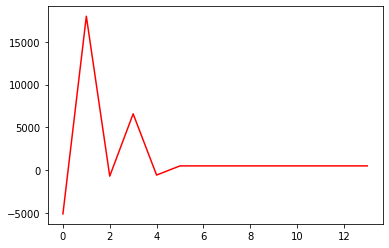

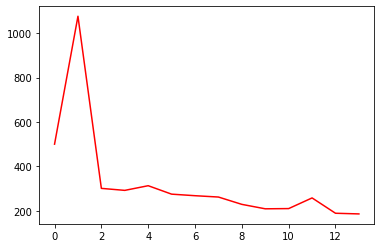

In [101]:
fips = 36061

deaths = list(util.get_deaths_list(fips, convert_date_to_yyyy_mm_dd(two_weeks_ago)))
#cases = list(util.get_cases_list(fips, convert_date_to_yyyy_mm_dd(two_weeks_ago)))
#cases = cases[-(in_steps*2 + 1):]

x_input = array(deaths[-(in_steps+1):])

x_input_differenced = array(util.get_differenced_list(x_input))
x_input = x_input_differenced.reshape(1, in_steps, 1)

#x_input = x_input.reshape(1, in_steps, 1)

preds = model.predict(x_input)
preds = util.inverse_differenced_list(deaths[-1], preds)

print(preds)
util.plot_list(preds[0])

actual_deaths = list(util.get_deaths_list(fips, convert_date_to_yyyy_mm_dd(today)))[-14:]
util.plot_list(actual_deaths)

In [ ]:
deaths = util.get_deaths_list(36061, convert_date_to_yyyy_mm_dd(today))
differenced = util.get_differenced_list(deaths)
util.plot_list(util.inverse_differenced_list(deaths[0], differenced))
util.plot_list(differenced)

In [ ]:
deaths = util.get_deaths_list(36061, convert_date_to_yyyy_mm_dd(today))
x_input = (deaths[-29:])[:15]

y_true = x_input[-1]
x_input_differenced = array(util.get_differenced_list(x_input))
x_input = x_input_differenced.reshape(1, 14, 1)

out = model.predict(x_input)
out = util.inverse_differenced_list(y_true, out)
print(out)

In [ ]:
util.plot_list(out[0])
util.plot_list(deaths)